In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [13]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [15]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

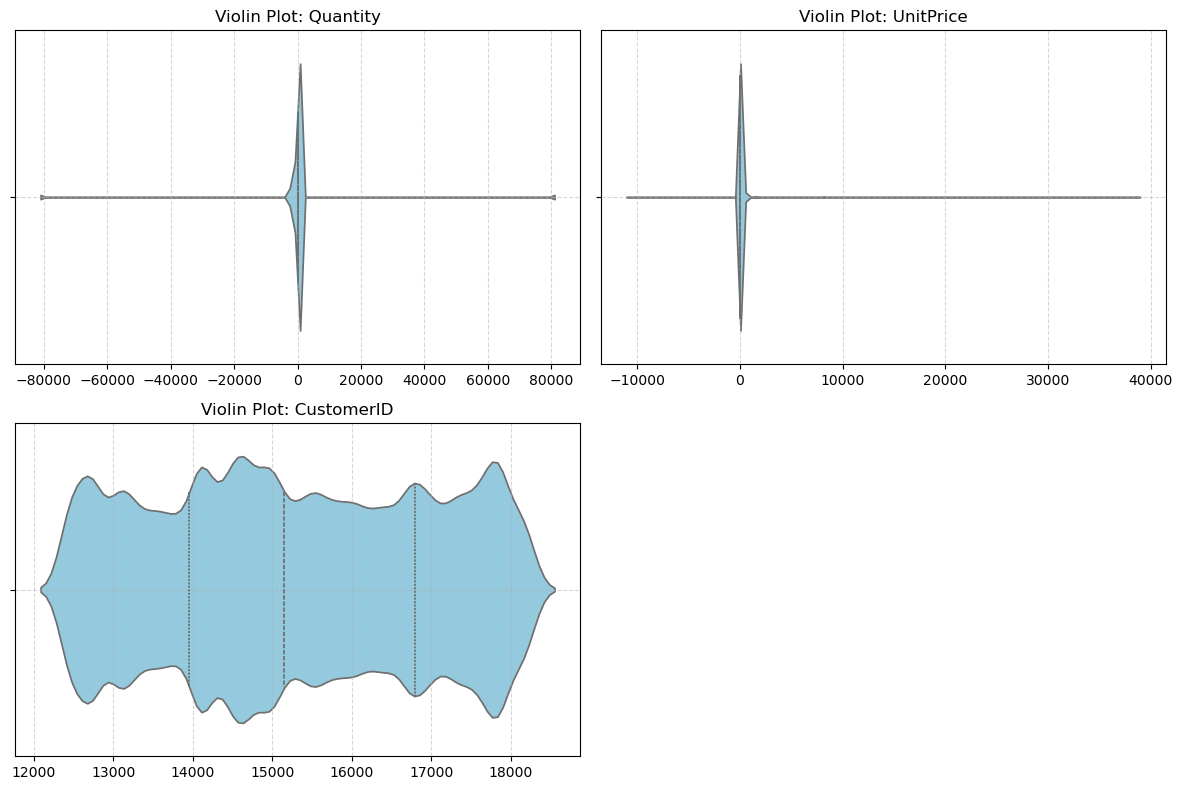

In [19]:
plt.figure(figsize=(12, 8))

# Loop through numerical columns to create subplots
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, (len(num_cols) + 1) // 2, i)
    sns.violinplot(x=df[col], color="skyblue", inner="quartile")
    plt.title(f"Violin Plot: {col}")
    plt.xlabel("")  # Remove x-label to keep it clean
    plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [21]:
# Step 1: Handle Missing Values
df = df.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID
df = df.drop(columns=['Description'])  # Remove unnecessary text column

In [23]:
# There are some negative values in Quantity and Unit price Handling it

# Step 2: Remove Cancellations (Negative Quantities)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]  # Ensure valid transactions

In [25]:
# Step 4: Calculate Total Spending per Transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [27]:
# Step 5: Aggregate Data by CustomerID for Clustering
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',      # Total spending
    'Quantity': 'sum',        # Total items purchased
    'InvoiceNo': 'nunique'    # Number of transactions
}).rename(columns={'InvoiceNo': 'NumTransactions'})

In [29]:
# Log transform to reduce skewness (adding 1 to avoid log(0))
customer_data[['TotalPrice', 'Quantity']] = np.log1p(customer_data[['TotalPrice', 'Quantity']])

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data)

In [33]:
print("Preprocessed Data Shape:", X_scaled.shape)
customer_data.head()

Preprocessed Data Shape: (4338, 3)


,TotalPrice,Quantity,NumTransactions
CustomerID,,,
12346.0,11.253955,11.214735,1
12347.0,8.368925,7.807510,7
12348.0,7.494564,7.758761,4
12349.0,7.472245,6.448889,1
12350.0,5.815324,5.288267,1


         TotalPrice   Quantity  NumTransactions
Cluster                                        
0          5.185264   4.413506         1.283694
1          6.445155   5.890380         2.414164
2          9.300052   8.699427        23.369565
3          7.800990   7.280337         6.322307
4         10.774052  10.306704       121.750000


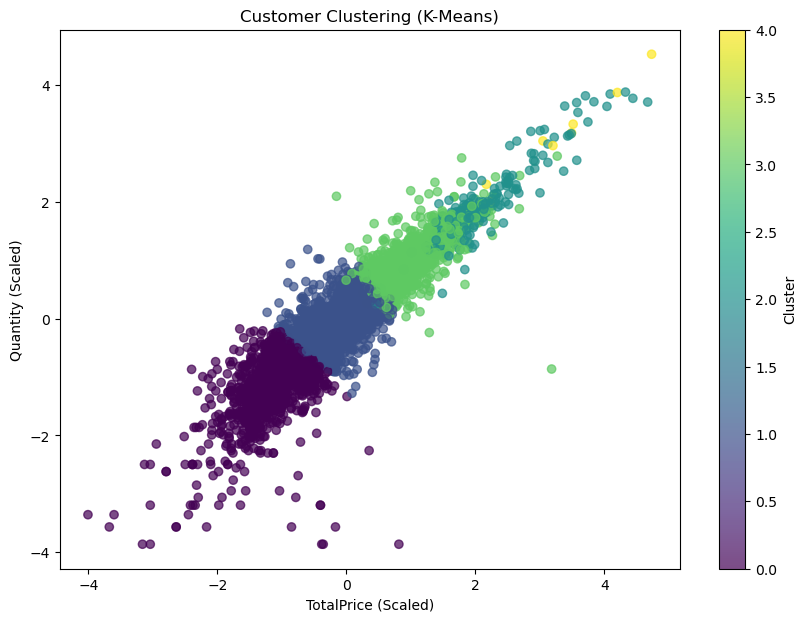

In [35]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 3: Analyze Cluster Characteristics
print(customer_data.groupby('Cluster').mean())

# Step 4 (Optional): Scatter Plot for Visualization (Only for 2D Projection)
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.title("Customer Clustering (K-Means)")
plt.colorbar(label="Cluster")
plt.show()

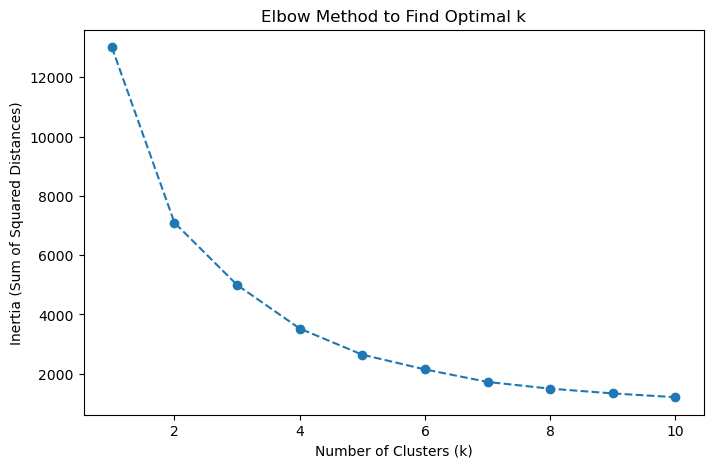

In [37]:
from sklearn.cluster import KMeans

# Step 1: Find the optimal number of clusters using Elbow Method
inertia = []
K_range = range(1, 11)  # Checking for k = 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method to Find Optimal k")
plt.show()

        TotalPrice         Quantity       NumTransactions      
              mean count       mean count            mean count
Cluster                                                        
0         6.840959  1873   6.309576  1873        3.183663  1873
1         5.387328  1639   4.666478  1639        1.394753  1639
2        10.832794    22  10.250163    22       77.454545    22
3         8.360556   804   7.806621   804       10.670398   804


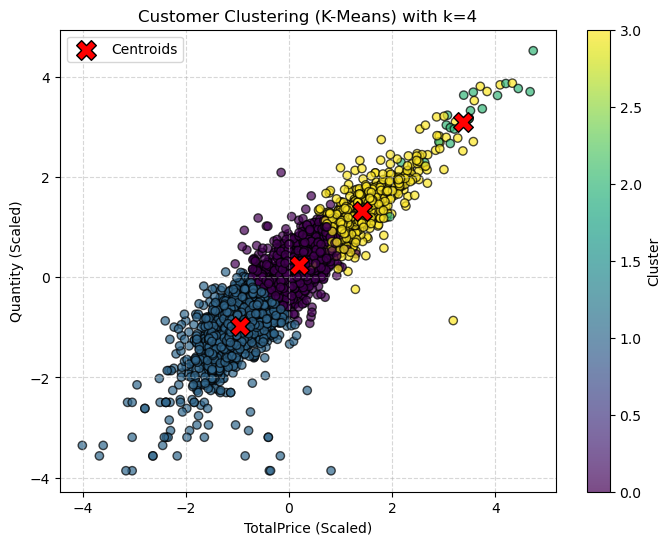

In [39]:
k = 4  # Assume k from elbow method
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 2: Analyze Cluster Characteristics
cluster_summary = customer_data.groupby('Cluster').agg(['mean', 'count'])
print(cluster_summary)

# Step 3: Scatter Plot for Visualization (Only for 2D Projection)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7, edgecolors='k')

# Plot cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X', edgecolors='black', label='Centroids')

plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.title(f"Customer Clustering (K-Means) with k={k}")
plt.colorbar(scatter, label="Cluster")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [43]:
from sklearn.metrics import silhouette_score

# Function to compute silhouette score for different k values
def compute_silhouette_scores(X, max_k=10):
    scores = {}
    for k in range(2, max_k + 1):  # Silhouette is only valid for k >= 2
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score
        print(f"Silhouette Score for k={k}: {score:.3f}")
    
    return scores

# Compute silhouette scores up to k=10
silhouette_scores = compute_silhouette_scores(X_scaled, max_k=10)

# Find the best k based on silhouette score
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nBest k based on Silhouette Score: {best_k} with score {silhouette_scores[best_k]:.3f}")


Silhouette Score for k=2: 0.495
Silhouette Score for k=3: 0.491
Silhouette Score for k=4: 0.434
Silhouette Score for k=5: 0.422
Silhouette Score for k=6: 0.417
Silhouette Score for k=7: 0.393
Silhouette Score for k=8: 0.361
Silhouette Score for k=9: 0.348
Silhouette Score for k=10: 0.349

Best k based on Silhouette Score: 2 with score 0.495
